### **Clustering based Course Recommender System**


In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn

%matplotlib inline

#### **Performing K-means clustering algorithm on the user profile feature vectors**

In [2]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [3]:
def load_course_genres():
    return pd.read_csv('course_genre.csv')

def load_ratings():
    return pd.read_csv('ratings.csv')

In [4]:
def kMeans_data_prep():

    rating_df = load_ratings()
    course_genres_df = load_course_genres()
    course_genres_matrix = course_genres_df.iloc[:,2:].to_numpy()

    profile_df = pd.DataFrame(columns = ['User_ID'] + list(course_genres_df.columns[2:]))

    for user_id in rating_df['user'].sort_values().unique():
        user = np.array(
                    pd.merge(course_genres_df, rating_df[rating_df['user'] == user_id], left_on = 'COURSE_ID', right_on = 'item', how= 'left')['rating'].fillna(0.0)    
                ).reshape(1, -1)

        user_profile = pd.DataFrame(
            np.matmul(user, course_genres_matrix),
            columns=course_genres_df.columns[2:]
        )

        user_profile['User_ID'] = user_id  
        profile_df = pd.concat([profile_df, user_profile], ignore_index=True)

    feature_names = list(profile_df.columns[1:])
    scaler = sklearn.preprocessing.StandardScaler()
    profile_df[feature_names] = scaler.fit_transform(profile_df[feature_names])

    user_features_df = profile_df.loc[:, profile_df.columns != 'User_ID']
    user_ids2_idx = profile_df.loc[:, profile_df.columns == 'User_ID']

    return user_ids2_idx, user_features_df

In [5]:
user_ids2_idx, user_features_df = kMeans_data_prep()
user_features_df.head()

C:\Users\Manoj\AppData\Local\Temp\ipykernel_15076\2707378856.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  profile_df = pd.concat([profile_df, user_profile], ignore_index=True)


,Database,Python,CloudComputing,DataAnalysis,Containers,MachineLearning,ComputerVision,DataScience,BigData,Chatbot,R,BackendDev,FrontendDev,Blockchain
0,6.106474,2.485388,0.961242,8.272010,0.850889,6.477594,-0.024296,4.571668,5.023412,1.456642,7.249771,7.360899,6.369323,2.570116
1,4.529980,-0.353377,0.440653,5.120792,-0.424767,2.368540,-0.024296,2.851031,2.667576,-0.438787,2.127032,0.865416,-0.231621,0.519419
2,2.427988,1.066006,4.084776,4.280467,-0.424767,5.828796,-0.024296,3.233395,1.281790,1.456642,5.542191,5.505047,2.702132,2.570116
3,-0.462250,-0.826504,-0.600526,-0.341319,-0.424767,-0.659184,-0.024296,-0.972608,-0.381153,-0.438787,-0.434337,-0.526473,-0.231621,-0.505930
4,0.063248,-0.826504,-0.600526,0.078843,-0.424767,-0.659184,-0.024296,-0.972608,0.173161,-0.438787,0.419453,-0.526473,-0.231621,-0.505930


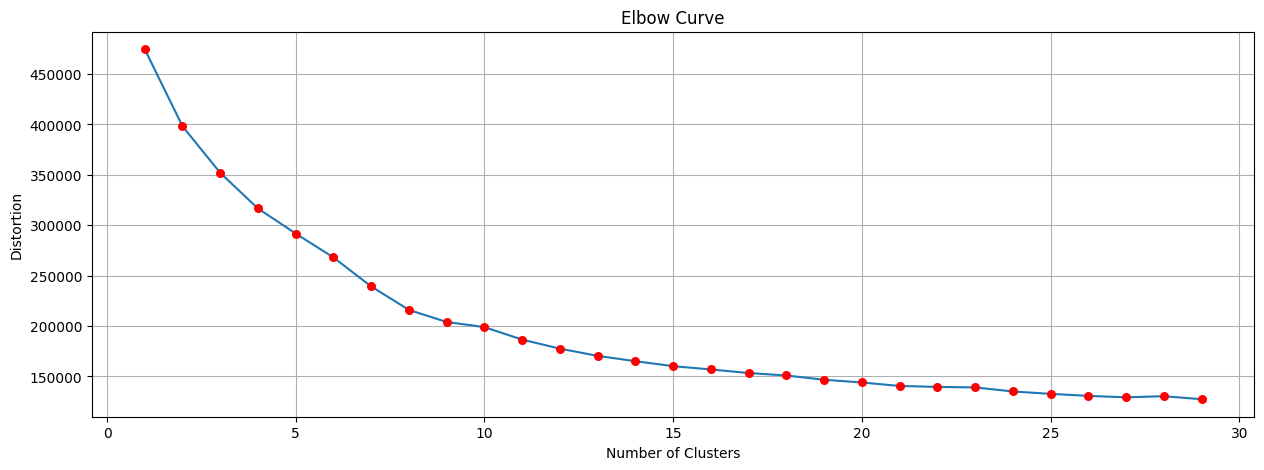

In [6]:
# Finding an optimized number of neighors k from a candidate list such as list_k = list(range(1, 30))
distorsions = []

for k in range(1, 30):
    kmeans = sklearn.cluster.KMeans(n_clusters=k)
    kmeans.fit(user_features_df)
    distorsions.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(1, 30), distorsions, label='Distortion')
plt.scatter(range(1, 30), distorsions, color='red', s=30, zorder=5, label='Points')
plt.grid(True)
plt.title('Elbow Curve')
plt.xlabel('Number of Clusters')
plt.ylabel('Distortion')
plt.show()

In [7]:
def kMeans_train(user_ids2_idx, user_features_df, n_clusters):
    
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(user_features_df)

    user_cluster_label = kmeans.labels_
    user_cluster_label_df = pd.DataFrame(user_cluster_label)
    user_cluster_label_df = pd.merge(user_ids2_idx, user_cluster_label_df, left_index=True, right_index=True)
    user_cluster_label_df.columns = ['user', 'cluster']
    
    return user_cluster_label_df

In [8]:
user_cluster_label_df = kMeans_train(user_ids2_idx, user_features_df, 25)
user_cluster_label_df.head()

,user,cluster
0,2,6
1,4,6
2,5,22
3,7,1
4,8,1


In [9]:
def kMeans_pred(user_cluster_labels, user_id):

    rating_df = load_ratings()

    user_cluster = user_cluster_labels[user_cluster_labels['user'] == user_id]['cluster'].values[0]
    similar_users = user_cluster_labels[(user_cluster_labels['cluster'] == user_cluster) & (user_cluster_labels['user'] != user_id)]
    sim_course_df = pd.merge(similar_users, rating_df, on = 'user')[['item', 'rating']]
    sim_course_df['count'] = [1] * len(sim_course_df)
    sim_course_df = (sim_course_df.groupby(['item'])
                        .agg(enrollments = ('count', 'sum'))
                        .sort_values(by='enrollments', ascending=False)
                        .reset_index()
                        )

    enrolled_courses = rating_df[rating_df['user'] == user_id]['item'].values
    sim_course_df = sim_course_df[~sim_course_df['item'].isin(enrolled_courses)]
    sim_course_df['enrollments'] = (sim_course_df['enrollments'] / sim_course_df['enrollments'].max()) * 100
    return sim_course_df

In [10]:
kMeans_pred(user_cluster_label_df, 2).head(10)

,item,enrollments
3,DS0101EN,100.000000
6,BD0115EN,97.087379
7,DS0105EN,96.116505
30,ML0151EN,62.621359
31,DB0151EN,60.679612
32,ML0101ENv3,58.252427
42,ML0111EN,42.718447
50,TA0105EN,28.155340
52,CC0101EN,26.213592
55,DW0101EN,25.728155


#### **Applying PCA on user profile feature vectors to reduce dimensions**


In [11]:
feature_names = list(user_features_df.columns)
print(f"There are {len(feature_names)} features for each user profile.")

There are 14 features for each user profile.


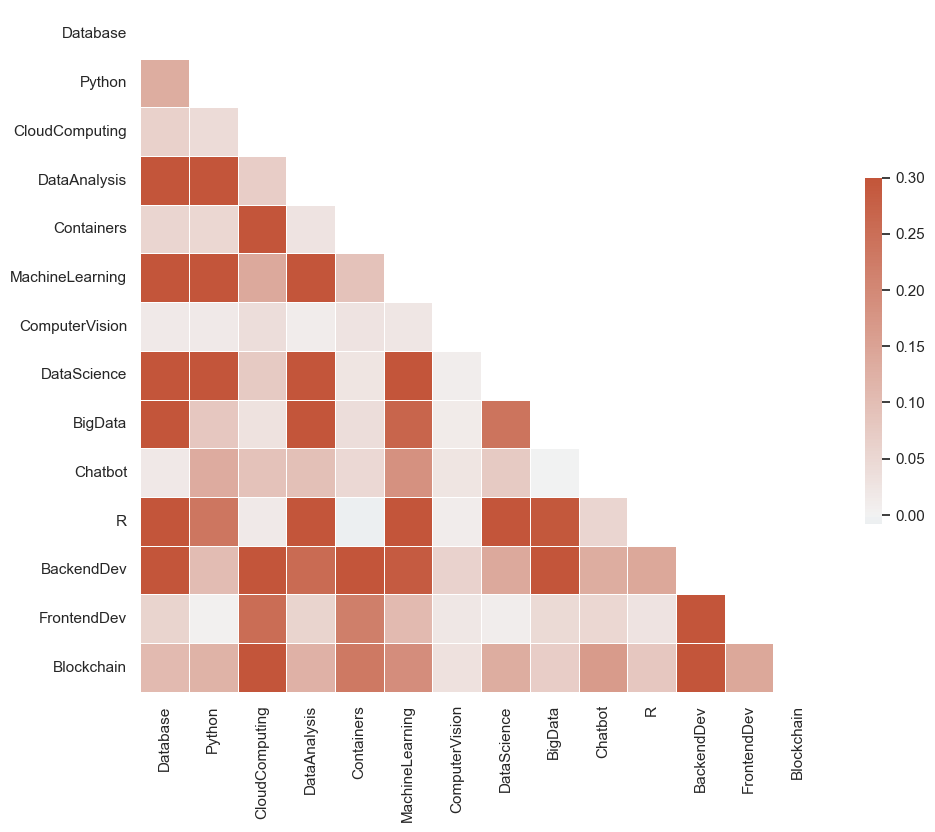

In [12]:
sns.set_theme(style="white")
corr = user_features_df.cov()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

For example, the feature `MachineLearning` and the feature `DataScience` are correlated. Such covariances among features may indicate that we can apply PCA to find its main components (eigenvectors with max eigenvalues on the covariance matrix).



In [13]:
# Finding the optimal value of n_components
accVarRatio = []

for n_components in range(1, 15):
    pca = sklearn.decomposition.PCA(n_components=n_components)
    pca.fit(user_features_df)

    print('For',n_components,'n_components the explained variance is :',pca.explained_variance_ratio_.sum())

    accVarRatio.append(pca.explained_variance_ratio_.sum())

For 1 n_components the explained variance is : 0.2875684338769967
For 2 n_components the explained variance is : 0.4630925644817449
For 3 n_components the explained variance is : 0.5761339643675616
For 4 n_components the explained variance is : 0.6487465627832343
For 5 n_components the explained variance is : 0.7194878762997212
For 6 n_components the explained variance is : 0.7882103410314037
For 7 n_components the explained variance is : 0.8429558465572831
For 8 n_components the explained variance is : 0.8944445500368897
For 9 n_components the explained variance is : 0.9272695591307679
For 10 n_components the explained variance is : 0.9544658170614699
For 11 n_components the explained variance is : 0.973357210316477
For 12 n_components the explained variance is : 0.9870310843021103
For 13 n_components the explained variance is : 0.997916316661769
For 14 n_components the explained variance is : 0.9999999999999999


<Axes: xlabel='n_component', ylabel='accumulated variance ratio'>

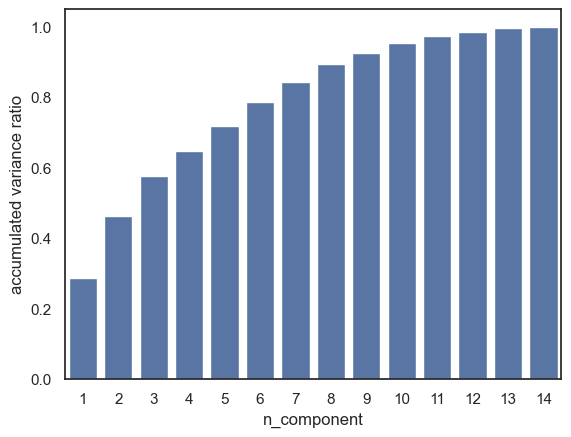

In [14]:
plot_df = pd.DataFrame({'n_component': range(1, 15), 'accumulated variance ratio': accVarRatio})
sns.barplot(x='n_component', y='accumulated variance ratio', data=plot_df)

In [15]:
def do_PCA(user_features_df, expected_variance = 90):

    expected_variance = expected_variance / 100
    n_com = 0

    for n_components in range(1, user_features_df.shape[1]):
        n_com = n_components
        pca = sklearn.decomposition.PCA(n_components=n_components)
        transformed_matrix = pca.fit_transform(user_features_df)
        if (sum(pca.explained_variance_ratio_) >= expected_variance): break

    transformed_df = pd.DataFrame(transformed_matrix)
    transformed_df.columns = [f"PC_{i}" for i in range(n_com)]

    return transformed_df

In [16]:
user_PCA_features_df = do_PCA(user_features_df, 90)
user_PCA_features_df.head()

,PC_0,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8
0,17.772494,0.200681,1.730609,2.567359,-3.825814,-2.707154,0.681042,2.312613,0.868272
1,7.145199,-2.847481,2.358636,-0.576654,0.398803,0.134533,0.549769,0.469033,0.033405
2,11.363270,1.873619,-1.522077,1.076144,-1.711688,-0.883212,1.677582,2.937669,2.097639
3,-1.834033,-0.277462,0.564905,0.053470,-0.064440,-0.165757,0.030956,0.039519,0.210887
4,-1.049125,-0.684767,1.072765,0.006371,-0.005695,-0.118686,0.118559,0.559292,0.186379


#### **Performing k-means clustering on the PCA transformed feature vectors**

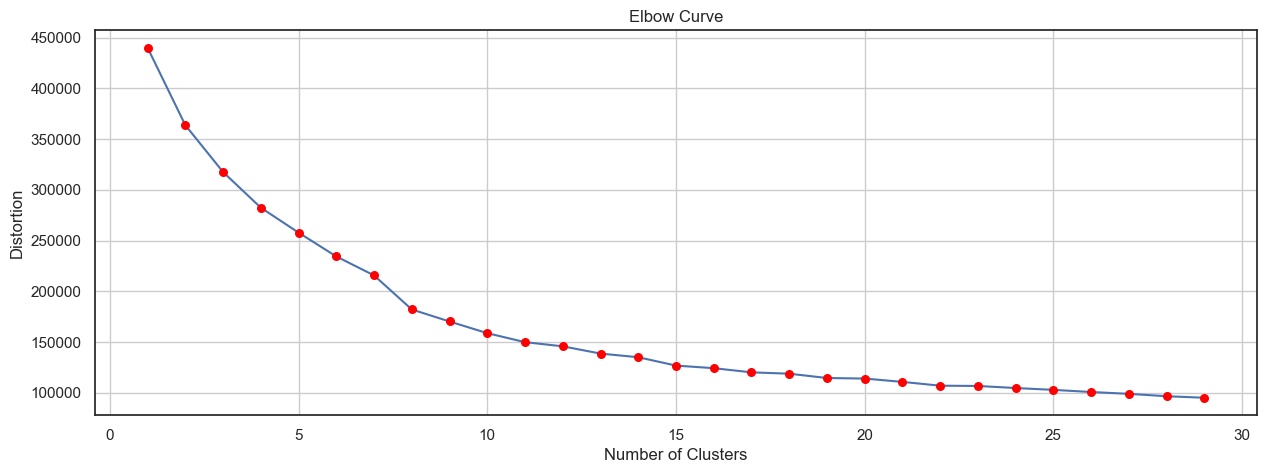

In [17]:
distorsions = []
for k in range(1, 30):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(user_PCA_features_df)
    distorsions.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(1, 30), distorsions, label='Distortion')
plt.scatter(range(1, 30), distorsions, color='red', s=30, zorder=5, label='Points')
plt.grid(True)
plt.title('Elbow Curve')
plt.xlabel('Number of Clusters')
plt.ylabel('Distortion')
plt.show()

In [18]:
user_cluster_label_df = kMeans_train(user_ids2_idx, user_PCA_features_df, 25)
user_cluster_label_df.head()

,user,cluster
0,2,15
1,4,11
2,5,15
3,7,10
4,8,5


In [19]:
kMeans_pred(user_cluster_label_df, 2).head(10)

,item,enrollments
5,DS0105EN,100.000000
6,DS0101EN,99.346405
9,BD0115EN,95.424837
25,ML0151EN,75.163399
30,DB0151EN,65.359477
33,ML0101ENv3,64.052288
41,ML0111EN,50.326797
49,TA0105EN,33.333333
52,DW0101EN,30.718954
58,CC0101EN,25.490196
